In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score
from itertools import product
from sklearn.model_selection import StratifiedKFold
import optuna
import plotly.express as px
from collections import Counter
import umap
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def fill_repeater_from_source(row, data):
    if row['Source'] == 'FRB20220912A':
        return 1
    else:
        return row['Repeater']

In [3]:
frb_data = pd.read_csv('frb-data.csv')
frb_data['Repeater'] = frb_data['Repeater'].map({'Yes': 1, 'No': 0})
frb_data['Repeater'] = frb_data['Repeater'].fillna(0)
frb_data['Repeater'] = frb_data['Repeater'].astype(int)
frb_data['Repeater'] = frb_data.apply(fill_repeater_from_source, axis=1, data=frb_data)

frb_data['Repeater'].isna().sum()

np.int64(0)

In [4]:
labels = frb_data['Repeater']

# Function to clean numerical strings and convert to float
def clean_numeric_value(value):
    if isinstance(value, str):
        value = value.strip()
        if not value:
            return np.nan
        try:
            # Remove special characters and split if necessary
            for char in ['/', '+', '<', '>', '~']:
                value = value.replace(char, '')
            if '-' in value:
                value = value.split('-')[0]
            return float(value)
        except ValueError:
            return np.nan
    try:
        return float(value)
    except (ValueError, TypeError):
        return np.nan
    
error_features = [
    'DM_SNR', 'DM_alig', 'Flux_density', 'Fluence', 'Energy',
    'Polar_l', 'Polar_c', 'RM_syn', 'RM_QUfit', 'Scatt_t', 
    #'Scin_f'
]
base_features = [
    'Observing_band', 
    #'GL', 'GB', 
    'SNR', 'Freq_high',
    'Freq_low', 'Freq_peak', 
    'Width'
    # 'Repeater',
    #'MJD'
]

for feature in base_features + error_features:
    frb_data[feature] = frb_data[feature].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_err'] = frb_data[f'{feature}_err'].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_upper'] = frb_data[feature] + frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[feature] - frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[f'{feature}_lower'].clip(lower=0)

features = (
    base_features +
    error_features +
    [f'{feature}_upper' for feature in error_features] +
    [f'{feature}_lower' for feature in error_features]
)

In [5]:
frb_data_clean = frb_data[features].fillna(0)
scaler = StandardScaler()
frb_data_scaled = scaler.fit_transform(frb_data_clean)

# Retain the original indices
indices = frb_data_clean.index

# Split the data and retain indices
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
class SupervisedVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.3, activation=nn.LeakyReLU(0.1)):
        super(SupervisedVAE, self).__init__()

        self.activation = activation

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),  # Additional dense layer
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate)
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),  # Additional dense layer
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)
        )

        # Classification head for binary classification - tune hyperparameters
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),  # Added extra linear layer
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 4, 1),
        )


    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        class_prob = self.classifier(mu)
        return recon_x, mu, logvar, class_prob


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = val_tensor.shape[1]
hidden_dim = 256
latent_dim = 10
stop_patience = 8
num_epochs = 150

In [8]:
def loss_function(recon_x, x, mu, logvar, class_prob, labels, beta, gamma, class_weight, classification_multiplier):
    reconstruction_loss_fn = nn.MSELoss(reduction='sum')
    pos_weight = torch.tensor([class_weight], dtype=torch.float32, device=device)
    classification_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # check this loss function
    recon_loss = reconstruction_loss_fn(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    class_loss = classification_multiplier * classification_loss_fn(class_prob, labels.unsqueeze(1).float())
    total_loss = recon_loss + beta * kl_loss + gamma * class_loss
    return total_loss, recon_loss, kl_loss, class_loss

In [9]:
def train_supervised(model, optimizer, scheduler, epoch, beta, gamma, class_weight, classification_multiplier):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, class_logits = model(data)
        
        # Supervised loss function
        loss, recon_loss, kl_loss, classification_loss = loss_function(
            recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
        )
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        classification_loss_total += classification_loss.item()
        
        predicted = (class_logits > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
        
        # if batch_idx % 100 == 0:
            # print(classification_loss)
            # print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
            #       f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_total / len(train_loader.dataset)
    avg_kl = kl_loss_total / len(train_loader.dataset)
    avg_class = classification_loss_total / len(train_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def validate_supervised(model, scheduler, optimizer, epoch, beta, gamma, class_weight, classification_multiplier):
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            recon_batch, mu, logvar, class_logits = model(data)
            
            loss, recon_loss, kl_loss, classification_loss = loss_function(
                recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
            )
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
            classification_loss_total += classification_loss.item()
            
            predicted = (class_logits > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = val_loss / len(val_loader.dataset)
    avg_recon = recon_loss_total / len(val_loader.dataset)
    avg_kl = kl_loss_total / len(val_loader.dataset)
    avg_class = classification_loss_total / len(val_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Validation loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy


def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False



In [10]:
def evaluate_classifier(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='weighted')

    
    false_positives = np.sum((all_labels == 0) & (all_preds == 1))

    return accuracy, class_report, conf_matrix, recall, false_positives  # Return F1 score as well

def get_activation_function(name):
    if name == 'ReLU':
        return nn.ReLU()
    elif name == 'LeakyReLU':
        return nn.LeakyReLU(0.1)
    elif name == 'ELU':
        return nn.ELU()
    elif name == 'SELU':
        return nn.SELU()
    elif name == 'GELU':
        return nn.GELU()
    else:
        raise ValueError(f"Unknown activation function: {name}")

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
import sklearn.metrics

def evaluate_classifier_full(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = sklearn.metrics.f1_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return f1, class_report, conf_matrix, all_preds, all_labels

original_data = pd.read_csv('frb-data.csv')
original_data['Repeater'] = original_data['Repeater'].map({'Yes': 1, 'No': 0})
print(original_data['Repeater'].isna().sum())

print(f"Number of NaN values in 'Repeater' column before processing: {original_data['Repeater'].isna().sum()}")
# Apply the function row-wise
original_data['Repeater'] = original_data.apply(fill_repeater_from_source, axis=1, data=original_data)

print(f"Number of NaN values in 'Repeater' column after processing: {original_data['Repeater'].isna().sum()}")

443
Number of NaN values in 'Repeater' column before processing: 443
Number of NaN values in 'Repeater' column after processing: 0


In [12]:
garcia_list = '''
FRB20180907E
FRB20180920B
FRB20180928A
FRB20181017B
FRB20181022E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181214A
FRB20181220A
FRB20181226E
FRB20181229B
FRB20190112A
FRB20190128C
FRB20190206B
FRB20190206A
FRB20190218B
FRB20190223A
FRB20190308C
FRB20190308C
FRB20190323D
FRB20190329A
FRB20190410A
FRB20190412B
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190527A
FRB20190527A
FRB20190601C
FRB20190601C
FRB20190617B
FRB20180910A
FRB20190210C
FRB20200726D
'''.split()

luo_list = '''
FRB20181229B
FRB20190423B
FRB20190410A
FRB20181017B
FRB20181128C
FRB20190422A
FRB20190409B
FRB20190329A
FRB20190423B
FRB20190206A
FRB20190128C
FRB20190106A
FRB20190129A
FRB20181030E
FRB20190527A
FRB20190218B
FRB20190609A
FRB20190412B
FRB20190125B
FRB20181231B
FRB20181221A
FRB20190112A
FRB20190125A
FRB20181218C
FRB20190429B
FRB20190109B
FRB20190206B
'''.split()

zhu_ge_list = '''
FRB20180911A
FRB20180915B
FRB20180920B
FRB20180923A
FRB20180923C
FRB20180928A
FRB20181013E
FRB20181017B
FRB20181030E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181130A
FRB20181214A
FRB20181220A
FRB20181221A
FRB20181226E
FRB20181229B
FRB20181231B
FRB20190106B
FRB20190109B
FRB20190110C
FRB20190111A
FRB20190112A
FRB20190129A
FRB20190204A
FRB20190206A
FRB20190218B
FRB20190220A
FRB20190221A
FRB20190222B
FRB20190223A
FRB20190228A
FRB20190308C
FRB20190308C
FRB20190308B
FRB20190308B
FRB20190323D
FRB20190329A
FRB20190403E
FRB20190409B
FRB20190410A
FRB20190412B
FRB20190418A
FRB20190419A
FRB20190422A
FRB20190422A
FRB20190423A
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190517C
FRB20190527A
FRB20190527A
FRB20190531C
FRB20190601B
FRB20190601C
FRB20190601C
FRB20190609A
FRB20190617A
FRB20190617B
FRB20190618A
FRB20190625A
'''.split()

In [13]:

best_params = {'hidden_dim': 1060, 'latent_dim': 15, 'beta': 0.556066849630894, 'gamma': 1.028589573645326, 'dropout_rate': 0.13107914006971386, 'lr': 0.00458414460664942, 'scheduler_patience': 4, 'class_weight': 0.7171123349525421, 'activation': 'ReLU', 'classification_multiplier': 6355.785108343389}

beta = best_params["beta"]
gamma = best_params["gamma"]
lr = best_params["lr"]
scheduler_patience = best_params["scheduler_patience"]
num_epochs = 150

In [14]:
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

source_data_val = list(original_data.loc[val_indices, "Source"])
source_data_val

source_data_train = list(original_data.loc[train_indices, "Source"])



In [15]:
best_params

{'hidden_dim': 1060,
 'latent_dim': 15,
 'beta': 0.556066849630894,
 'gamma': 1.028589573645326,
 'dropout_rate': 0.13107914006971386,
 'lr': 0.00458414460664942,
 'scheduler_patience': 4,
 'class_weight': 0.7171123349525421,
 'activation': 'ReLU',
 'classification_multiplier': 6355.785108343389}

In [16]:
def get_source_data_val_freq(n=20):
    global source_data_val
    label_counts = Counter(source_data_val)
    top_labels = [label for label, _ in label_counts.most_common(n)]
    source_data_val_freq = [label if label in top_labels else 'Other' for label in source_data_val]

    return source_data_val_freq

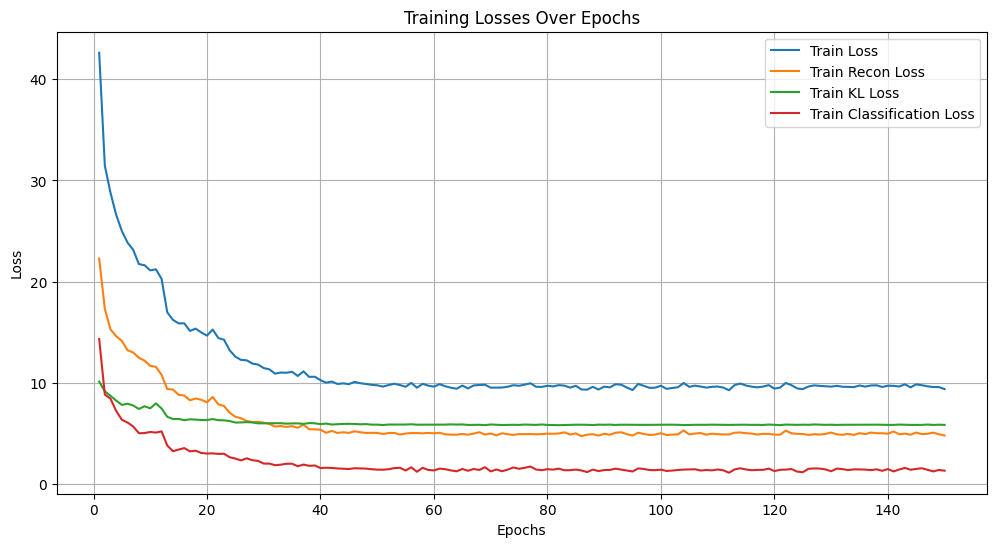

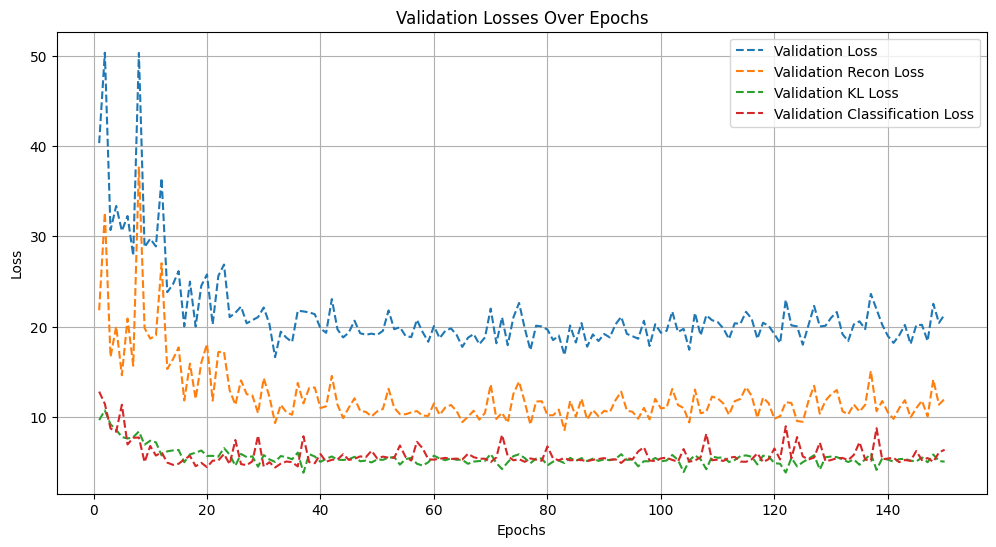

In [19]:
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

best_model = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)

# Initialize lists to store loss values
epochs_list = []
train_losses, val_losses = [], []
train_recon_losses, val_recon_losses = [], []
train_kl_losses, val_kl_losses = [], []
train_class_losses, val_class_losses = [], []

# Train the model
for epoch in range(1, num_epochs + 1):
    # avg_loss, avg_recon, avg_kl, avg_class, accuracy
    train_loss, train_recon_loss, train_kl_loss, train_class_loss, train_accuracy = train_supervised(
        best_model, optimizer, scheduler, epoch, beta, gamma, best_params["class_weight"], best_params["classification_multiplier"]
    )
    
    val_loss, val_recon_loss, val_kl_loss, val_class_loss, val_accuracy = validate_supervised(
        best_model, optimizer, scheduler, epoch, beta, gamma, best_params["class_weight"], best_params["classification_multiplier"]
    )
    scheduler.step(val_loss)
    
    # Store values for visualization
    epochs_list.append(epoch)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_recon_losses.append(train_recon_loss)
    val_recon_losses.append(val_recon_loss)
    train_kl_losses.append(train_kl_loss)
    val_kl_losses.append(val_kl_loss)
    train_class_losses.append(train_class_loss)
    val_class_losses.append(val_class_loss)
    
    # Early stopping
    if early_stopping([val_loss], stop_patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break

# Plot training losses
plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses, label='Train Loss', linestyle='-')
plt.plot(epochs_list, train_recon_losses, label='Train Recon Loss', linestyle='-')
plt.plot(epochs_list, train_kl_losses, label='Train KL Loss', linestyle='-')
plt.plot(epochs_list, train_class_losses, label='Train Classification Loss', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.grid()
plt.show()



# Plot validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs_list, val_losses, label='Validation Loss', linestyle='--')
plt.plot(epochs_list, val_recon_losses, label='Validation Recon Loss', linestyle='--')
plt.plot(epochs_list, val_kl_losses, label='Validation KL Loss', linestyle='--')
plt.plot(epochs_list, val_class_losses, label='Validation Classification Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Losses Over Epochs')
plt.legend()
plt.grid()
plt.show()



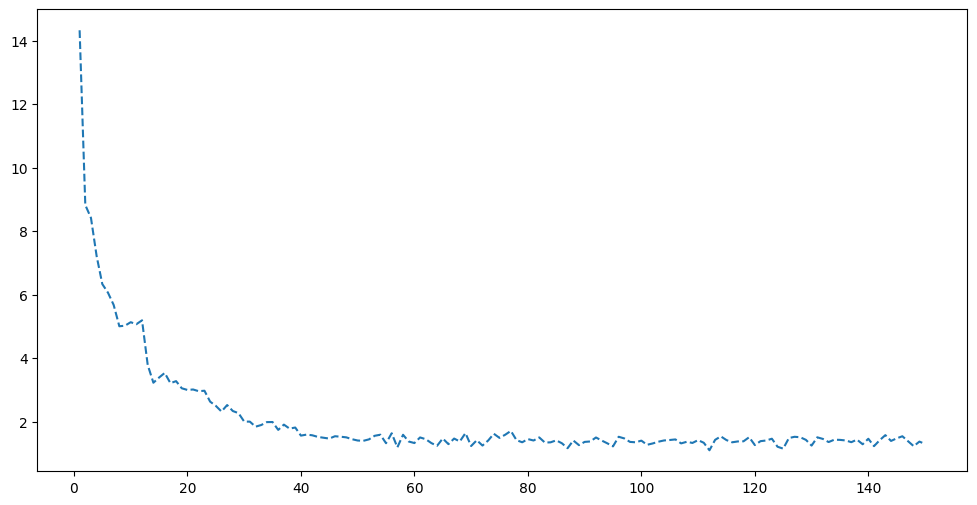

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_class_losses, label='Validation Loss', linestyle='--')

In [21]:
result = evaluate_classifier_full(best_model, val_loader, device)

result[2]

array([[ 137,   13],
       [   8, 1575]])

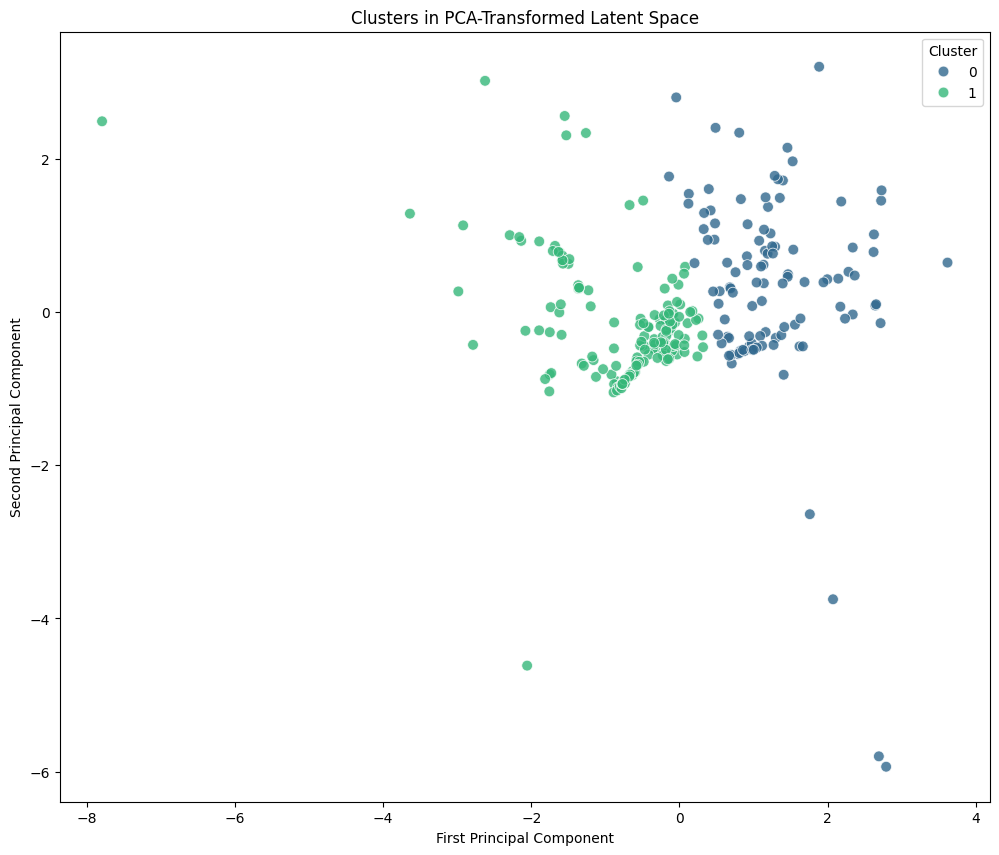

Silhouette Score: 0.4364493191242218
Adjusted Rand Index (ARI): 0.3733422329296987


In [24]:
def cluster_and_visualize(latent_representations, labels, title='Clusters in PCA-Transformed Latent Space'):
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    n_clusters = len(np.unique(labels))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_2d)
    
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=cluster_labels, palette='viridis', s=60, alpha=0.8)
    plt.title(title)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend(title="Cluster")
    plt.show()

    silhouette = silhouette_score(latent_2d, cluster_labels)
    print(f"Silhouette Score: {silhouette}")

    ari = adjusted_rand_score(labels, cluster_labels)
    print(f"Adjusted Rand Index (ARI): {ari}")

cluster_and_visualize(val_latent, val_labels_np)

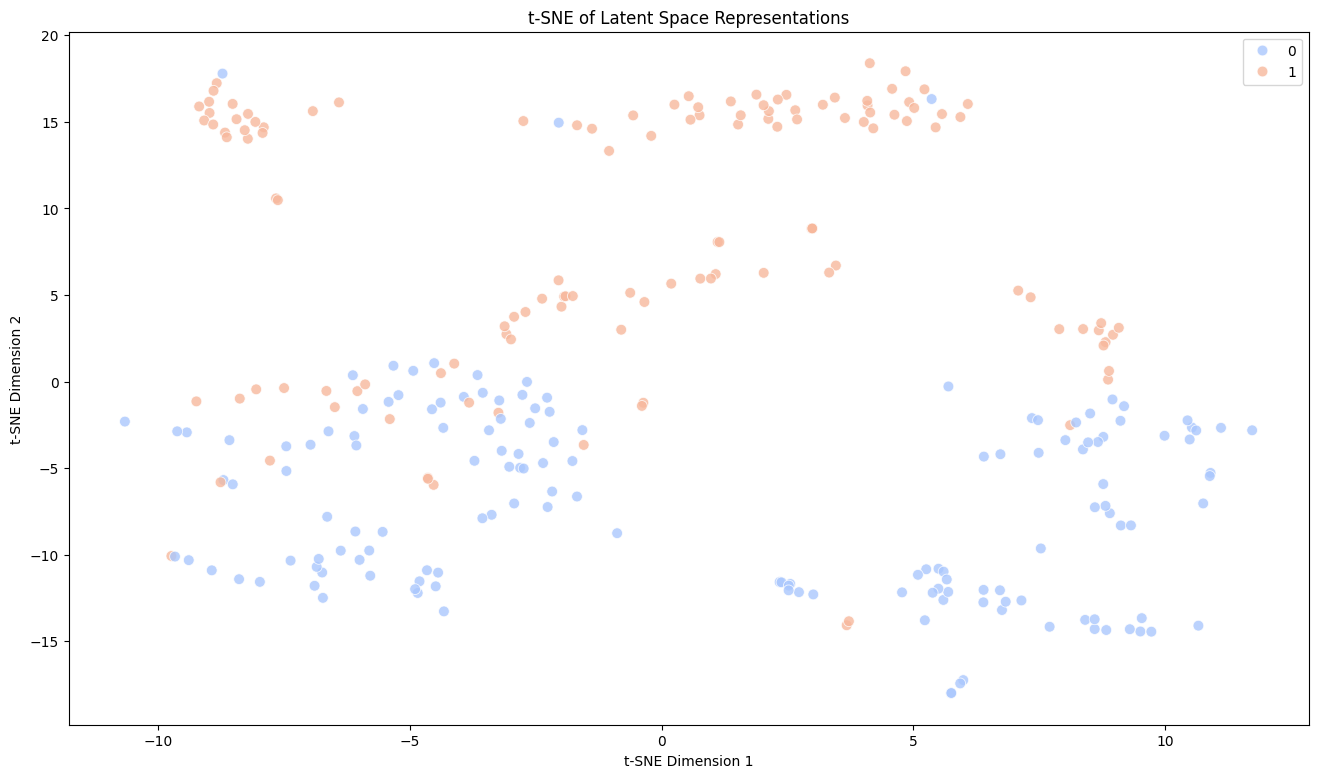

In [26]:
def visualize_latent_space_tsne(latent_representations, labels, title='t-SNE of Latent Space Representations', palette='tab20'):
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_representations)

    
    plt.figure(figsize=(16, 9))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette=palette, s=60, alpha=0.8)
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.savefig(f'{title}.png'.replace(' ', '_'), dpi=500)

    plt.show()

visualize_latent_space_tsne(val_latent, val_labels_np, palette='coolwarm')

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


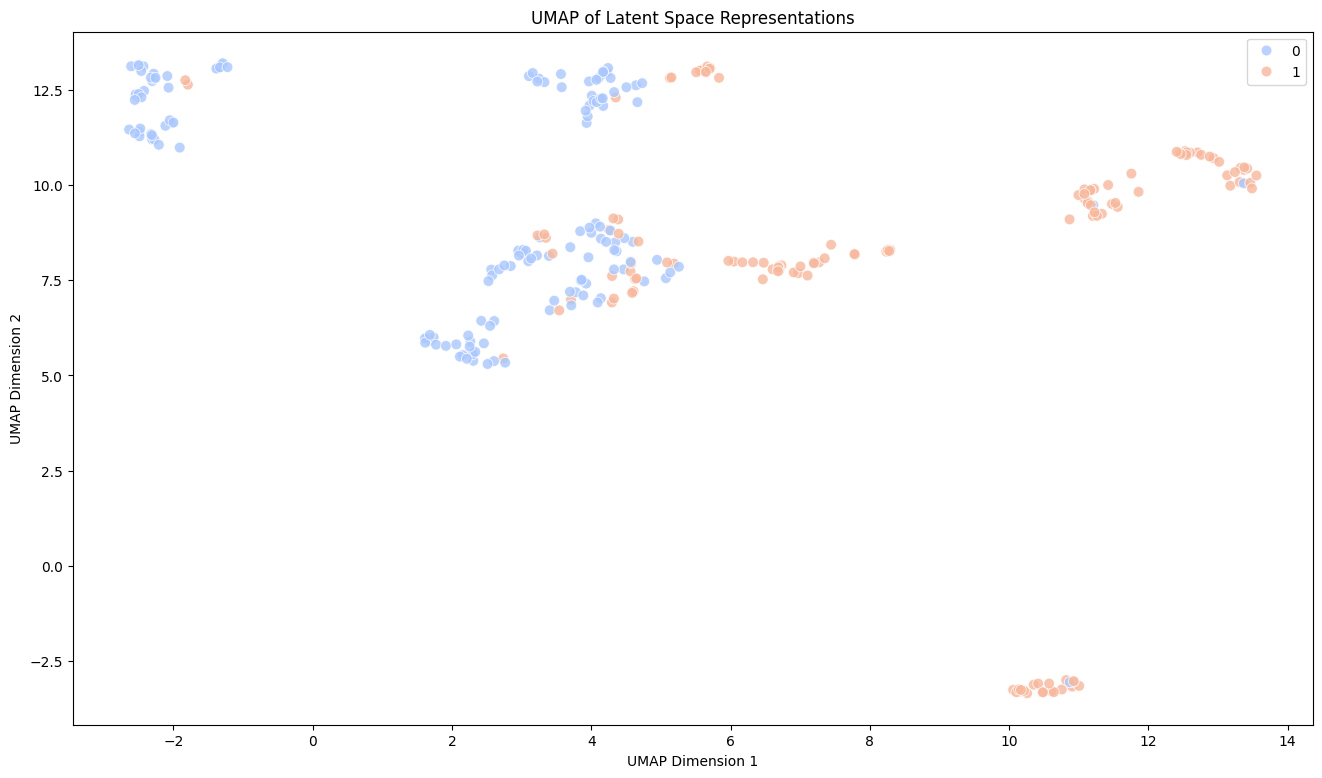

In [27]:
import umap

def visualize_latent_space_umap(latent_representations, labels, title="UMAP of Latent Space Representations", palette='tab20'):
    reducer = umap.UMAP(n_components=2, random_state=42)
    latent_2d = reducer.fit_transform(latent_representations)
        
    plt.figure(figsize=(16, 9))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette=palette, s=60, alpha=0.8)
    plt.title(title)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.savefig(f'{title}.png'.replace(' ', '_'), dpi=500)
    plt.show()

visualize_latent_space_umap(val_latent, val_labels_np, palette='coolwarm')

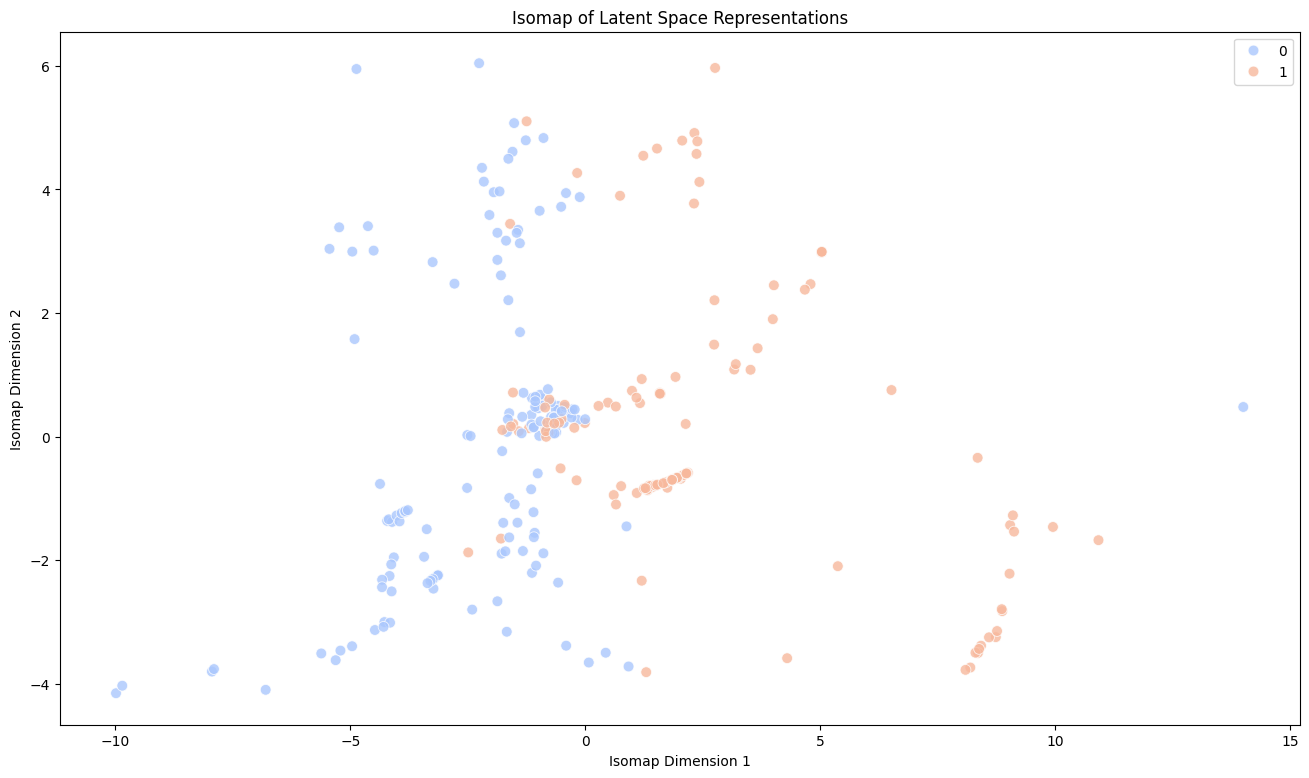

In [28]:
from sklearn.manifold import Isomap

def visualize_latent_space_isomap(latent_representations, labels, title="Isomap of Latent Space Representations"):
    isomap = Isomap(n_components=2)
    latent_2d = isomap.fit_transform(latent_representations)
    
    plt.figure(figsize=(16, 9))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette='coolwarm', s=60, alpha=0.8)
    plt.title(title)
    plt.xlabel('Isomap Dimension 1')
    plt.ylabel('Isomap Dimension 2')
    plt.show()

visualize_latent_space_isomap(val_latent, val_labels_np)

In [29]:
from sklearn.metrics import mutual_info_score

def mutual_information(latent_representations, labels):
    mi = mutual_info_score(labels, np.argmax(latent_representations, axis=1))
    print(f"Mutual Information between Latent Variables and Labels: {mi}")

mutual_information(val_latent, val_labels_np)

Mutual Information between Latent Variables and Labels: 0.1869389293944992


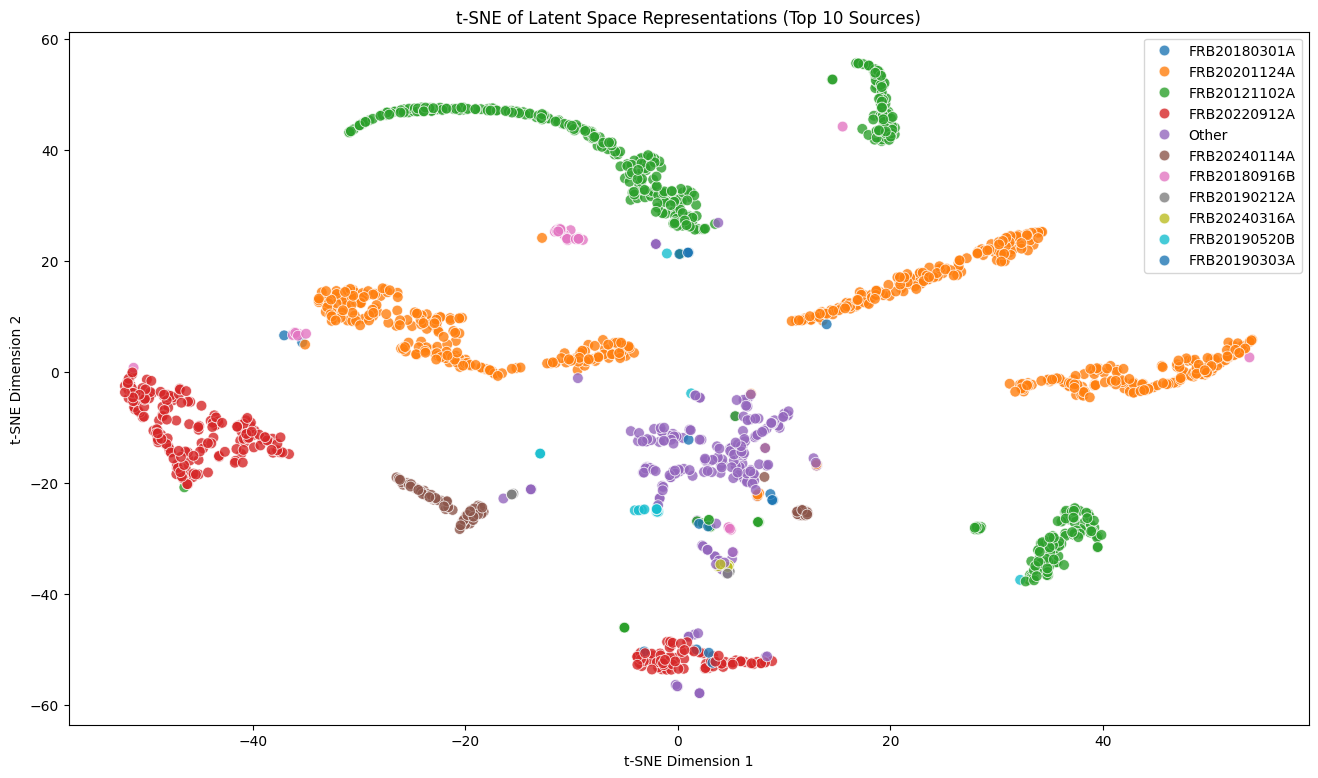

In [30]:
visualize_latent_space_tsne(val_latent, get_source_data_val_freq(10), title='t-SNE of Latent Space Representations (Top 10 Sources)', palette='tab10')

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


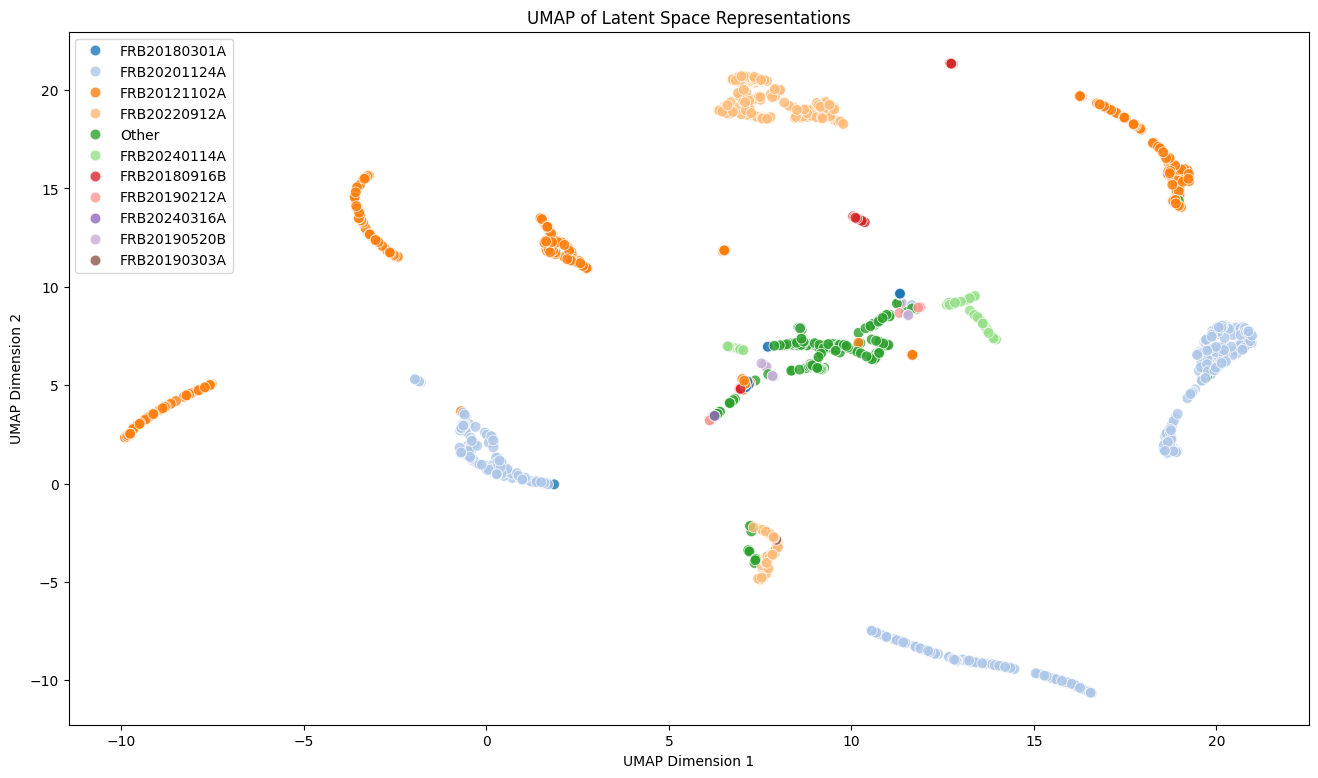

In [121]:
visualize_latent_space_umap(val_latent, get_source_data_val_freq(10))

In [36]:
# Step 1: Identify the 5 most frequent repeaters
repeater_counts = frb_data[frb_data['Repeater'] == 1]['Source'].value_counts()
top_5_repeaters = repeater_counts.head(5).index.tolist()

# # Step 2: Filter the dataset to exclude these repeaters
# filtered_indices = frb_data[~frb_data['Source'].isin(top_5_repeaters)].index
# filtered_data_clean = frb_data_clean.loc[filtered_indices]
# filtered_labels = labels.loc[filtered_indices]

top_5_repeaters = frb_data[frb_data['Repeater'] == 1]['Source'].value_counts().head(5).index.tolist()

# Sample 10 signals from each top repeater
sampled_indices = []
for repeater in top_5_repeaters:
    repeater_indices = frb_data[frb_data['Source'] == repeater].index
    sampled = np.random.choice(repeater_indices, size=min(5, len(repeater_indices)), replace=False)
    sampled_indices.extend(sampled)

# Get all other indices excluding the top 5 repeaters
non_top5_indices = frb_data[~frb_data['Source'].isin(top_5_repeaters)].index

# Combine the sampled top5 and the rest
final_indices = np.concatenate([non_top5_indices, sampled_indices])

# Filter the clean data and labels accordingly
filtered_data_clean = frb_data_clean.loc[final_indices]
filtered_labels = labels.loc[final_indices]


# Step 3: Standardize the filtered dataset
scaler = StandardScaler()
filtered_data_scaled = scaler.fit_transform(filtered_data_clean)

# Step 4: Split the filtered dataset into train and validation sets
train_data_filtered, val_data_filtered, train_labels_filtered, val_labels_filtered = train_test_split(
    filtered_data_scaled, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
)

# Step 5: Convert to PyTorch tensors
train_tensor_filtered = torch.tensor(train_data_filtered, dtype=torch.float32)
val_tensor_filtered = torch.tensor(val_data_filtered, dtype=torch.float32)
train_labels_tensor_filtered = torch.tensor(train_labels_filtered.values, dtype=torch.long)
val_labels_tensor_filtered = torch.tensor(val_labels_filtered.values, dtype=torch.long)

# Step 6: Create datasets and dataloaders
batch_size = 64
train_dataset_filtered = TensorDataset(train_tensor_filtered, train_labels_tensor_filtered)
val_dataset_filtered = TensorDataset(val_tensor_filtered, val_labels_tensor_filtered)

train_loader_filtered = DataLoader(train_dataset_filtered, batch_size=batch_size, shuffle=True)
val_loader_filtered = DataLoader(val_dataset_filtered, batch_size=batch_size, shuffle=False)

def train_supervised_filtered(model, optimizer, scheduler, epoch, beta, gamma, class_weight, classification_multiplier):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader_filtered):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, class_logits = model(data)
        
        # Supervised loss function
        loss, recon_loss, kl_loss, classification_loss = loss_function(
            recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
        )
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        classification_loss_total += classification_loss.item()
        
        predicted = (class_logits > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
        
        # if batch_idx % 100 == 0:
            # print(classification_loss)
            # print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
            #       f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_total / len(train_loader.dataset)
    avg_kl = kl_loss_total / len(train_loader.dataset)
    avg_class = classification_loss_total / len(train_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def validate_supervised_filtered(model, scheduler, optimizer, epoch, beta, gamma, class_weight, classification_multiplier):
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in val_loader_filtered:
            data, labels = data.to(device), labels.to(device)
            recon_batch, mu, logvar, class_logits = model(data)
            
            loss, recon_loss, kl_loss, classification_loss = loss_function(
                recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
            )
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
            classification_loss_total += classification_loss.item()
            
            predicted = (class_logits > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = val_loss / len(val_loader.dataset)
    avg_recon = recon_loss_total / len(val_loader.dataset)
    avg_kl = kl_loss_total / len(val_loader.dataset)
    avg_class = classification_loss_total / len(val_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Validation loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy


def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False


In [37]:


# Step 7: Train the model with the filtered dataset
best_model = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params["lr"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=best_params["scheduler_patience"])

num_epochs = 100
for epoch in range(1, num_epochs + 1):
    train_loss, _, _, _, train_accuracy = train_supervised_filtered(
        best_model, optimizer, scheduler, epoch, best_params["beta"], 
        best_params["gamma"], best_params["class_weight"], best_params["classification_multiplier"]
    )
    
    val_loss, _, _, _, val_accuracy = validate_supervised_filtered(
        best_model, optimizer, scheduler, epoch, best_params["beta"], 
        best_params["gamma"], best_params["class_weight"], best_params["classification_multiplier"]
    )
    scheduler.step(val_loss)
    
    if early_stopping([val_loss], stop_patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break

# Evaluate the model after training
val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(best_model, val_loader_filtered, device)

print("\n=== Final Evaluation ===")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)


=== Final Evaluation ===
Validation Accuracy: 0.8755
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.91      0.87      0.89       150
    Repeater       0.85      0.90      0.88       129

    accuracy                           0.88       279
   macro avg       0.88      0.88      0.88       279
weighted avg       0.88      0.88      0.88       279

Confusion Matrix:
 [[130  20]
 [ 13 116]]



=== PCA Visualization ===


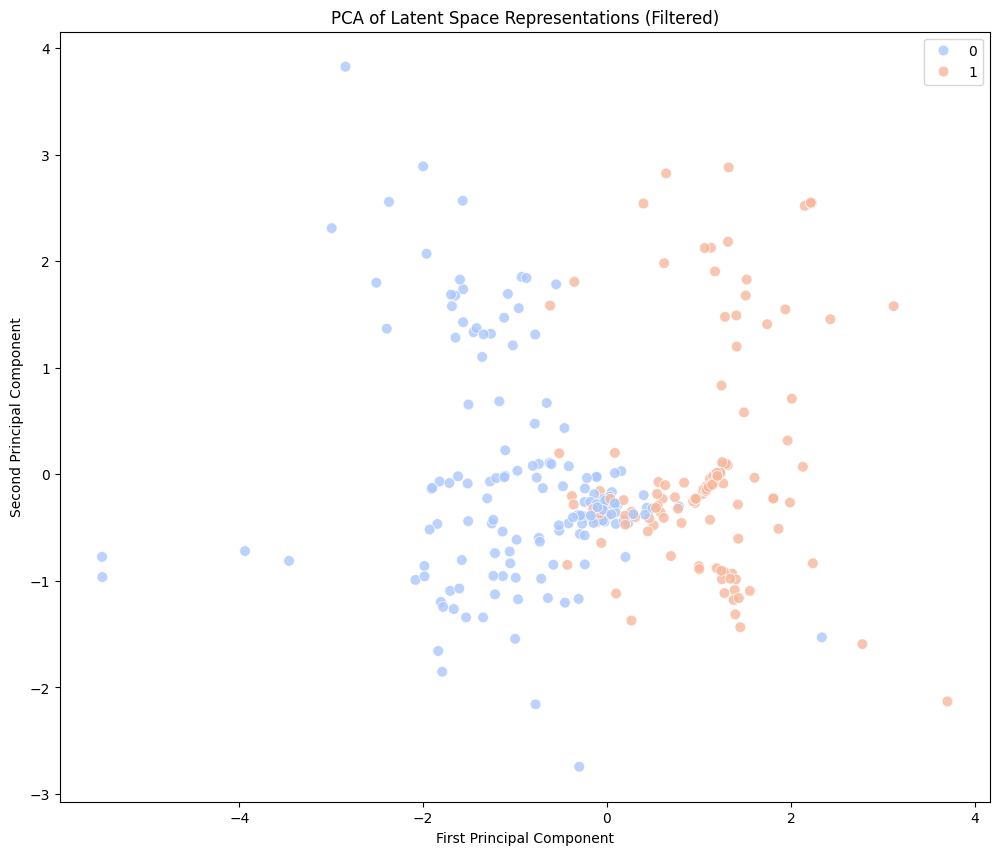


=== Clustering Analysis in Latent Space ===


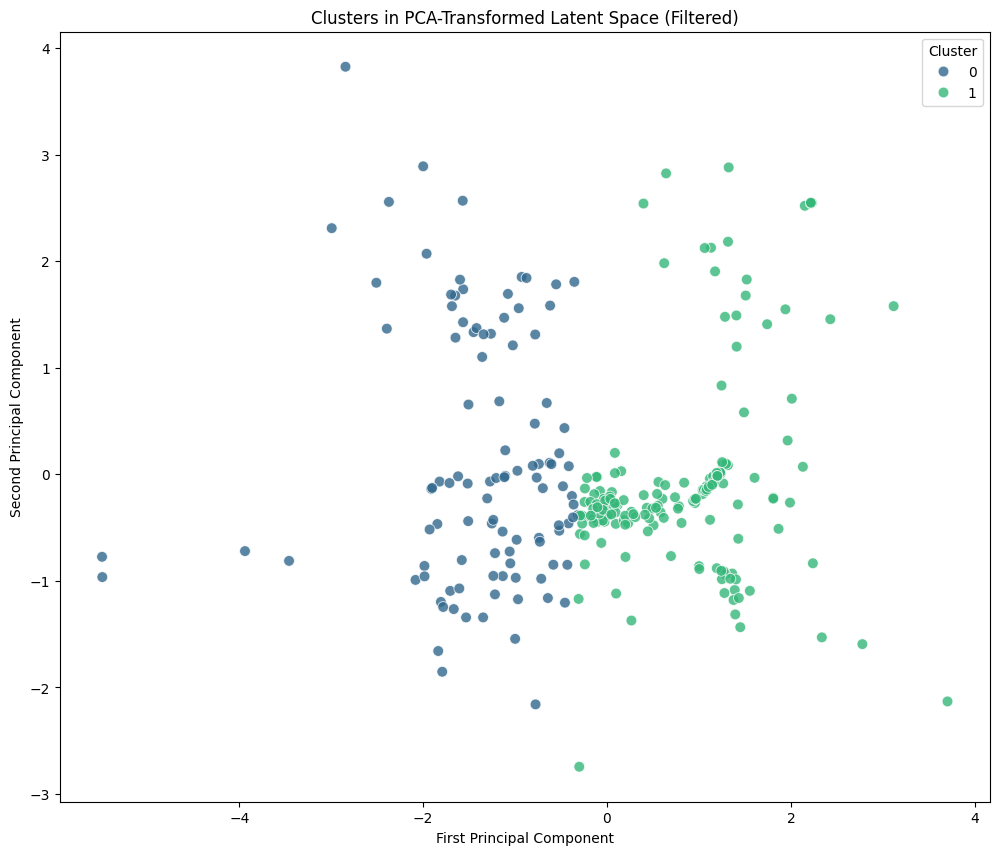

Silhouette Score: 0.39496976137161255
Adjusted Rand Index (ARI): 0.34733361917217337

=== t-SNE Visualization ===


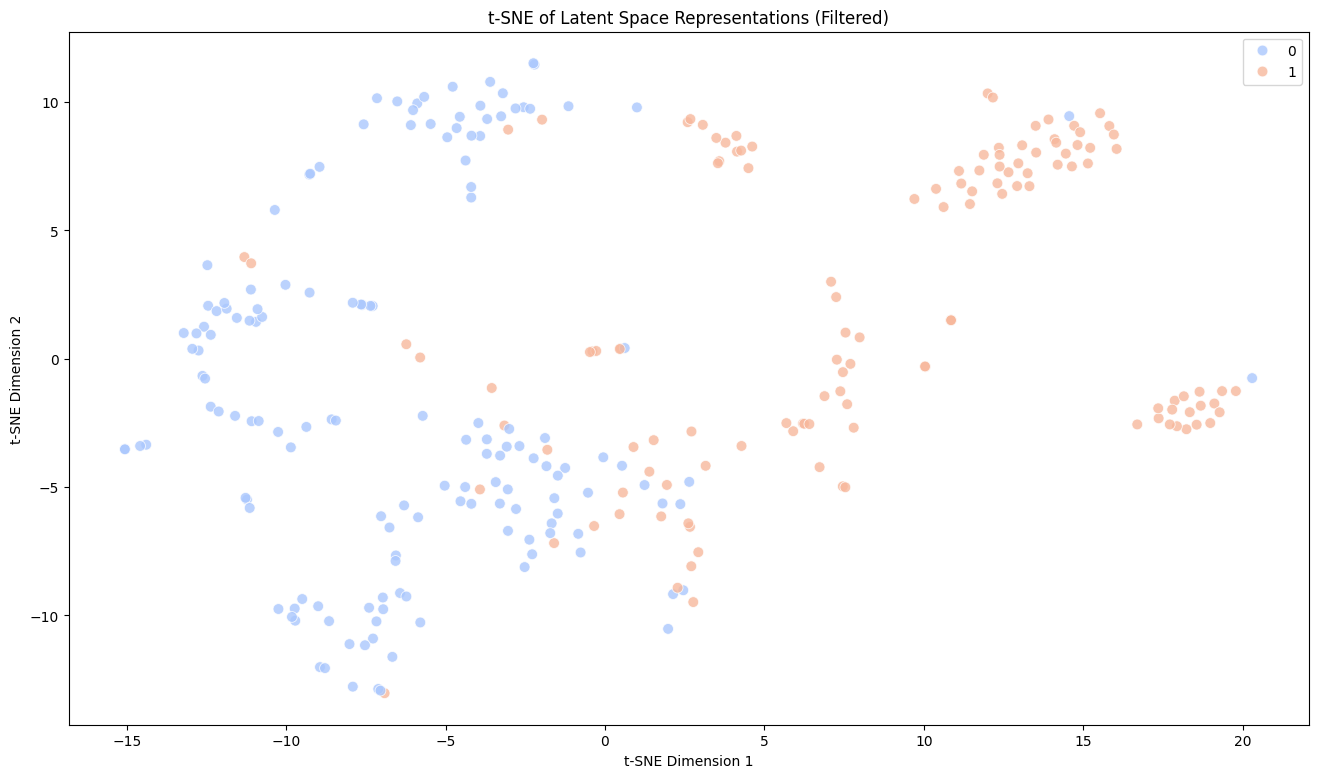


=== UMAP Visualization ===


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


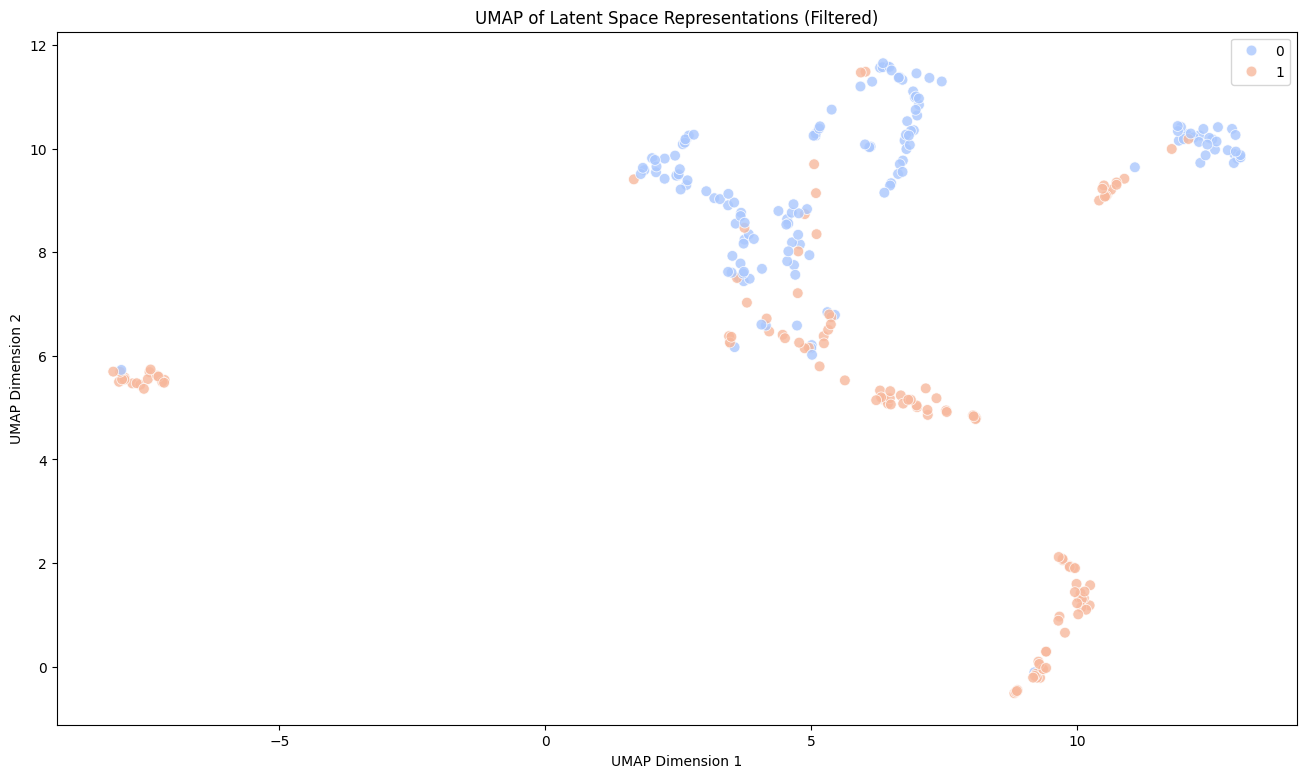


=== Isomap Visualization ===


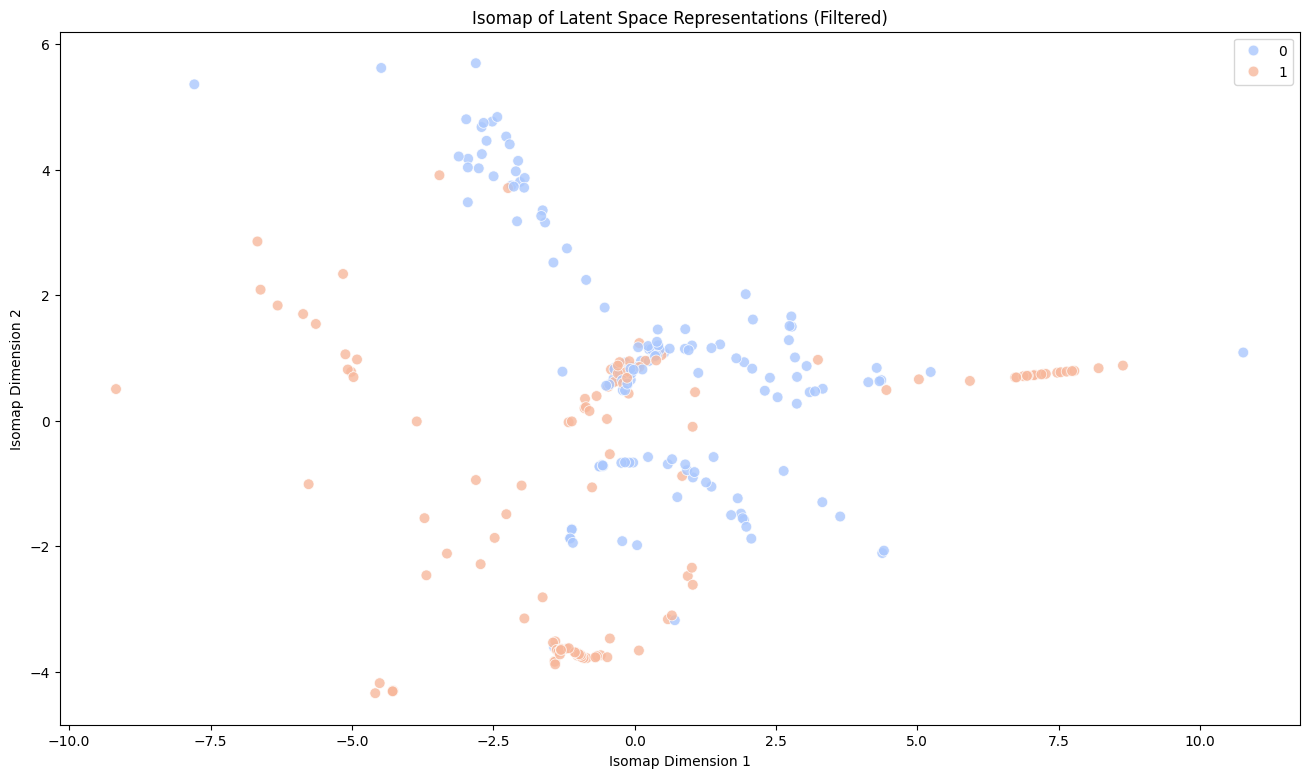

In [38]:
# Step 1: Extract latent representations
train_latent, train_labels_np = get_latent_representations(best_model, train_loader_filtered, device)
val_latent, val_labels_np = get_latent_representations(best_model, val_loader_filtered, device)

# Step 2: Visualize the latent space using PCA
print("\n=== PCA Visualization ===")
visualize_latent_space_pca(val_latent, val_labels_np, best_model, device, title='PCA of Latent Space Representations (Filtered)')

# Step 3: Perform clustering analysis
print("\n=== Clustering Analysis in Latent Space ===")
cluster_and_visualize(val_latent, val_labels_np, title='Clusters in PCA-Transformed Latent Space (Filtered)')

# Step 4: Visualize the latent space using t-SNE
print("\n=== t-SNE Visualization ===")
visualize_latent_space_tsne(val_latent, val_labels_np, title='t-SNE of Latent Space Representations (Filtered)', palette='coolwarm')

# Step 5: Visualize the latent space using UMAP
print("\n=== UMAP Visualization ===")
visualize_latent_space_umap(val_latent, val_labels_np, title='UMAP of Latent Space Representations (Filtered)', palette='coolwarm')

# Step 6: Visualize the latent space using Isomap
print("\n=== Isomap Visualization ===")
visualize_latent_space_isomap(val_latent, val_labels_np, title='Isomap of Latent Space Representations (Filtered)')


In [39]:


val_index = val_labels_filtered.index
val_sources = original_data.loc[val_index, 'Source'].values

latent_df = pd.DataFrame(
    val_latent, 
    index=val_index,
)
latent_df['Source'] = val_sources

db = DBSCAN(eps=1, min_samples=5).fit(val_latent)
latent_df['cluster'] = db.labels_

print("Cluster membership counts:\n", latent_df['cluster'].value_counts(), "\n")
print("Top 10 members of each non‑noise cluster:")
for cluster_label in sorted(latent_df['cluster'].unique()):
    if cluster_label >= 0:
        members = latent_df[latent_df['cluster']==cluster_label]['Source']
        print(f"Cluster {cluster_label}:", members.value_counts().head(10).to_dict())

nbrs = NearestNeighbors(n_neighbors=6).fit(val_latent)
distances, indices = nbrs.kneighbors(val_latent)



def find_similar(source):
    idx = latent_df[latent_df['Source'] == source].index[0]
    source_cluster = latent_df.loc[idx, 'cluster']
    
    # If it’s noise (cluster = -1), nothing to return
    if source_cluster == -1:
        return []
    
    pos = list(latent_df.index).index(idx)
    
    neighbors = {}
    for i, neighbor_pos in enumerate(indices[pos][1:]):
        neighbor_idx = latent_df.index[neighbor_pos]
        if latent_df.loc[neighbor_idx, 'cluster'] == source_cluster:
            neighbors[latent_df.loc[neighbor_idx, 'Source']] = float(distances[pos][i+1])


    return neighbors

print()
example = latent_df['Source'].iloc[2]
print(f"Top 5 same‑cluster FRBs similar to {example}:\n", find_similar(example))

Cluster membership counts:
 cluster
 1    164
-1     65
 2     20
 0     18
 4      7
 3      5
Name: count, dtype: int64 

Top 10 members of each non‑noise cluster:
Cluster 0: {'FRB20190520B': 17, 'FRB20181017A': 1}
Cluster 1: {'FRB20180301A': 7, 'FRB20190303A': 6, 'FRB20191106C': 6, 'FRB20180814A': 5, 'FRB20240316A': 5, 'FRB20200120E': 4, 'FRB20190915D': 3, 'FRB20181128A': 3, 'FRB20200929C': 2, 'FRB20200619A': 2}
Cluster 2: {'FRB20171004A': 1, 'FRB20000925A': 1, 'FRB20170107A': 1, 'FRB20170707A': 1, 'FRB20180814A': 1, 'FRB20010116A': 1, 'FRB20010823A': 1, 'FRB20010621B': 1, 'FRB20200915A': 1, 'FRB20200508A': 1}
Cluster 3: {'FRB20190417A': 5}
Cluster 4: {'FRB20190303A': 2, 'FRB20190212A': 1, 'FRB20180916B': 1, 'FRB20181030A': 1, 'FRB20180814A': 1, 'FRB20240114A': 1}

Top 5 same‑cluster FRBs similar to FRB20190128D:
 {'FRB20190320C': 0.1795004670796472, 'FRB20190124D': 0.2787983088116127, 'FRB20180909A': 0.30890636644883224, 'FRB20181118B': 0.3179431049299273, 'FRB20180915A': 0.3191445

In [40]:
for source in garcia_list:
    if source in latent_df['Source'].values:
        similar_source_data = find_similar(source)
        if similar_source_data != []:
            for similar_source in similar_source_data.keys():
                if original_data[original_data['Source'] == similar_source]['Repeater'].values[0] == 1:
                    print(f"{source} is similar to {similar_source} which is a repeater")

FRB20190112A is similar to FRB20191106C which is a repeater
FRB20190112A is similar to FRB20190915D which is a repeater
FRB20190601C is similar to FRB20180909A which is a repeater
FRB20190601C is similar to FRB20180909A which is a repeater


In [41]:
for source in zhu_ge_list:
    if source in latent_df['Source'].values:
        similar_source_data = find_similar(source)
        if similar_source_data != []:
            for similar_source in similar_source_data.keys():
                if original_data[original_data['Source'] == similar_source]['Repeater'].values[0] == 1:
                    print(f"{source} is similar to {similar_source} which is a repeater")

FRB20180911A is similar to FRB20190107B which is a repeater
FRB20181030E is similar to FRB20190107B which is a repeater
FRB20181231B is similar to FRB20190303A which is a repeater
FRB20190112A is similar to FRB20191106C which is a repeater
FRB20190112A is similar to FRB20190915D which is a repeater
FRB20190221A is similar to FRB20190107B which is a repeater
FRB20190517C is similar to FRB20190609C which is a repeater
FRB20190517C is similar to FRB20200929C which is a repeater
FRB20190517C is similar to FRB20200619A which is a repeater
FRB20190531C is similar to FRB20201221B which is a repeater
FRB20190531C is similar to FRB20180909A which is a repeater
FRB20190601C is similar to FRB20180909A which is a repeater
FRB20190601C is similar to FRB20180909A which is a repeater


In [52]:
for source in garcia_list:
    if source in zhu_ge_list and source in luo_list and source in latent_df['Source'].values:
            similar_source_data = find_similar(source)
            if similar_source_data != []:
                for similar_source, score in similar_source_data.items():
                    if frb_data[frb_data['Source'] == similar_source]['Repeater'].values[0] == 1:
                        print(f"{source} is similar to {similar_source} with a score of {score:.5f} which is a repeater")
                        

FRB20190112A is similar to FRB20191106C with a score of 0.81547 which is a repeater
FRB20190112A is similar to FRB20190915D with a score of 1.06287 which is a repeater


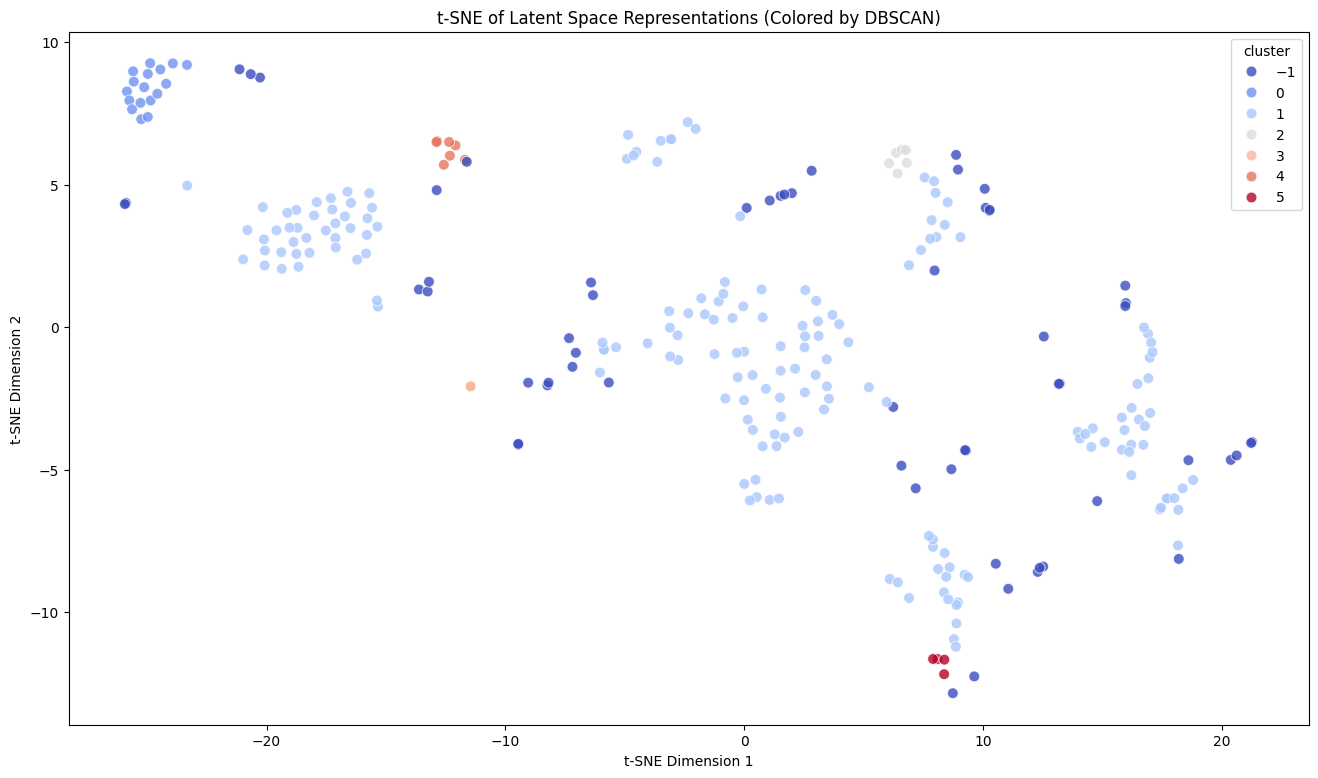

In [55]:
visualize_latent_space_tsne(val_latent, latent_df['cluster'], title='t-SNE of Latent Space Representations (Colored by DBSCAN)', palette='coolwarm')